venv:
- conda create -n pinn python=3
- conda activate pinn
- conda install jupyter numpy matplotlib
- conda install pytorch torchvision torchaudio -c pytorch

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [16]:
# Use cuda if available (use model.to(device) to run on device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
print(torch.version.cuda)         # Shows CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Should be True if GPU is usable

12.4
False


In [18]:
class Model(nn.Module):
    # defines a fully connected neural network, with a tanh activation function
    def __init__(self, inputs, outputs, hidden, n_layers):
        super().__init__()
        act_f = nn.Tanh

        # First layer, "*" unpacks the list into arguments of nn.Sequential
        self.fcs = nn.Sequential(*[
                        nn.Linear(inputs, hidden),
                        act_f()])
        
        # Hidden layers with activation function
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(hidden, hidden),
                            act_f()]) for _ in range(n_layers-1)])
        
        # Final layer that maps from last hidden layer to output size
        self.fce = nn.Linear(hidden, outputs)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Done step 0
Done step 50000
Done step 100000
Done step 150000


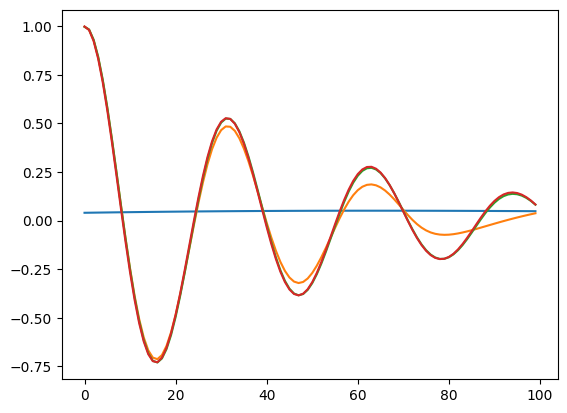

In [ ]:
# 1D spring simulation:
d, w0 = 2, 20 # Conditions for an under-dampened spring
mu, k = 2*d, w0**2

torch.manual_seed(42)
#model with 1 input and output layers (time and amplitude) and 4 hidden layers of 42 neurons
spring_model = Model(1, 1, 42, 4).to(device)
optimizer = torch.optim.Adam(spring_model.parameters(),lr=1e-4)

x_physics = torch.linspace(0,1,100).view(-1,1).requires_grad_(True) # generate time inputs
x_physics = x_physics.to(device)

last_res = np.array(0)

for i in range(150001):
    optimizer.zero_grad()
    
    # compute the "physics loss"
    yhp = spring_model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss_phys = (1e-4)*torch.mean(physics**2)

    #If time is 0, we want an amplitude of 1 (boundary condition)
    loss_BC = abs(1-yhp[0])
    
    # backpropagate joint loss
    loss = loss_phys + loss_BC# add two loss terms together
    loss.backward()
    optimizer.step()

    if i%50000 == 0:
        print(f"Done step {i}")
        to_display = yhp.cpu()
        to_display = to_display.detach().numpy()
        last_res = to_display
        plt.plot(to_display)



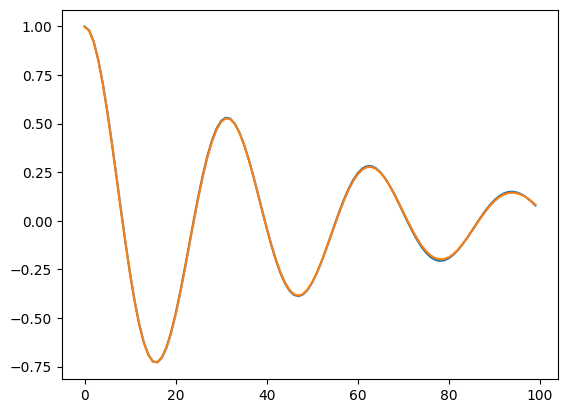

In [47]:
# Real spring, just to compare
def oscillator(d, w0, x):
    assert d < w0 # check if really underdampened
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

x = torch.linspace(0,1,100).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

plt.plot(y)
plt.plot(last_res)

In [19]:
def generate_points(N):
    # Define zones as (x_min, x_max, y_min, y_max, weight)
    zones = [
        (0, 0.4, -0.02, 0.02, 0.01),           # Base zone
        (0, 0.4, 0.01, 0.015, 0.03),          # Upper horizontal band
        (0, 0.4, -0.015, -0.01, 0.03),        # Lower horizontal band
        (0.19, 0.21, -0.01, 0.01, 0.05)           # Center square
    ]
    
    # Compute area and weighted area of each zone
    weighted_areas = []
    total_weighted_area = 0
    for x_min, x_max, y_min, y_max, weight in zones:
        area = (x_max - x_min) * (y_max - y_min)
        w_area = area * weight
        weighted_areas.append(w_area)
        total_weighted_area += w_area

    # Determine number of points per zone
    points_per_zone = [int((w_area / total_weighted_area) * N) for w_area in weighted_areas]

    # Sample points in each zone
    all_points = []
    for i, (x_min, x_max, y_min, y_max, _) in enumerate(zones):
        count = points_per_zone[i]
        xs = np.random.uniform(x_min, x_max, count)
        ys = np.random.uniform(y_min, y_max, count)
        all_points.append(np.column_stack((xs, ys)))

    # Combine all points into a single array
    points = np.vstack(all_points)

    return points

Reynolds number: 200.0


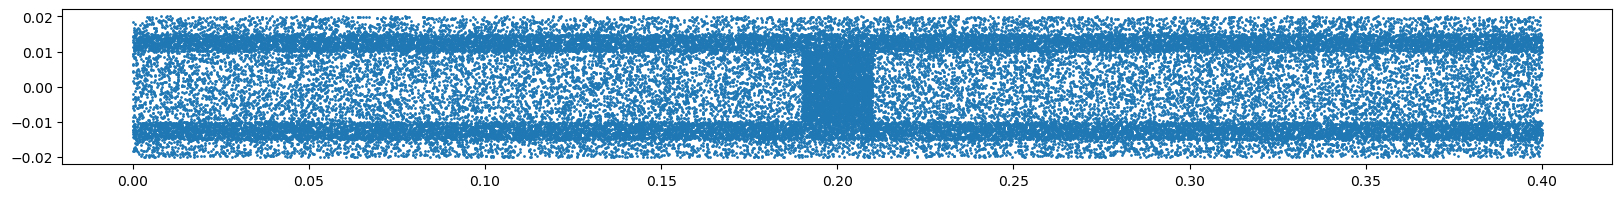

In [56]:
# Simulation parameters
h = 0.01
L = 0.2
u_avg = 0.01
rho = 1000
mu = 0.001
Re = (rho * u_avg * 2*h) / mu
print(f"Reynolds number: {Re}")

h_factor = 2 # y dim simulation factor (y_max, y_min = +-h * h_factor)
L_factor = 2 # x dim simulation factor (x_max, x_min = L * L_factor, 0)

torch.manual_seed(12)
#model with 2 input (x,y position), 3 output layers (x, y velocity & pressure) and 8 hidden layers of 50 neurons
poiseuille_model = Model(2, 3, 100, 5).to(device)
optimizer = torch.optim.Adam(poiseuille_model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

tensor_np = generate_points(50000)

tensor = torch.from_numpy(tensor_np).float().to(device).requires_grad_(True)

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect("equal")
ax.scatter(tensor_np[:,0], tensor_np[:,1], s = 1)

In [49]:
def compute_PDE(xy, y_in):
    u = y_in[:, 0:1]
    v = y_in[:, 1:2]
    p = y_in[:, 2:3]

    # Gradient helper
    grads = lambda out, inp: torch.autograd.grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True)[0]

    # First-order derivatives
    grads_u = grads(u, xy)
    grads_v = grads(v, xy)
    grads_p = grads(p, xy)

    dudx, dudy = grads_u[:, 0], grads_u[:, 1]
    dvdx, dvdy = grads_v[:, 0], grads_v[:, 1]
    dpdx, dpdy = grads_p[:, 0], grads_p[:, 1]

    # Second-order derivatives
    d2udx2 = grads(dudx, xy)[:, 0]
    d2udy2 = grads(dudy, xy)[:, 1]
    d2vdx2 = grads(dvdx, xy)[:, 0]
    d2vdy2 = grads(dvdy, xy)[:, 1]

    return dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2

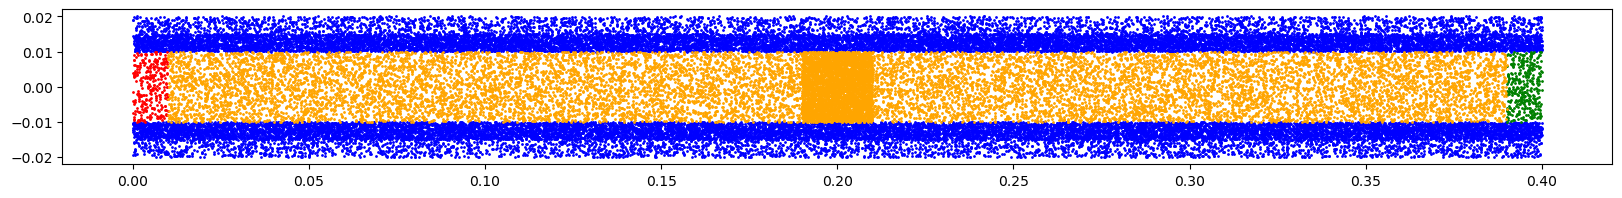

In [38]:
# Verify masks
omg = generate_points(50000)
t = torch.from_numpy(omg)
x_vals_tensor = t[:, 0]
y_vals_tensor = t[:, 1]

no_slip_mask = (y_vals_tensor < -h) | (y_vals_tensor > h)
inlet_mask = (torch.abs(x_vals_tensor - 0) < 1e-2) & (~no_slip_mask)
outlet_mask = (torch.abs(x_vals_tensor - L * L_factor) < 1e-2) & (~no_slip_mask)
interior_mask = ~(no_slip_mask | inlet_mask | outlet_mask)

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect("equal")
ax.scatter(t[no_slip_mask][:,0], t[no_slip_mask][:,1], s = 1, c = "blue")
ax.scatter(t[inlet_mask][:,0], t[inlet_mask][:,1], s = 1, c="red")
ax.scatter(t[outlet_mask][:,0], t[outlet_mask][:,1], s = 1, c="green")
ax.scatter(t[interior_mask][:,0], t[interior_mask][:,1], s = 1, c="orange")

In [ ]:
from tqdm import trange, tqdm

x_vals_tensor = tensor[:, 0]
y_vals_tensor = tensor[:, 1]

no_slip_mask = (y_vals_tensor < -h) | (y_vals_tensor > h)
inlet_mask = (torch.abs(x_vals_tensor - 0) < 1e-2) & (~no_slip_mask)
outlet_mask = (torch.abs(x_vals_tensor - L * L_factor) < 1e-2) & (~no_slip_mask)
interior_mask = ~(no_slip_mask | inlet_mask | outlet_mask)

vals_phys = []
vals_BC = []

for i in trange(10000):
    optimizer.zero_grad()
    
    # Boundray Conditions part
    yhp = poiseuille_model(tensor)

    p_outlet = yhp[outlet_mask, 2]

    outlet_loss = torch.mean(p_outlet**2) * 25
    no_slip_loss = torch.mean(yhp[no_slip_mask, 0])**2 + torch.mean(yhp[no_slip_mask, 1]**2) * 20
    inlet_loss = torch.mean((yhp[inlet_mask, 0] - u_avg)**2) + torch.mean((yhp[inlet_mask, 1])**2) * 20

    #Physics loss part
    x_interior = tensor[interior_mask]
    y_interior = poiseuille_model(x_interior)

    dudx, dudy, dpdx, dpdy, d2udx2, d2udy2, dvdx, dvdy, d2vdx2, d2vdy2 = compute_PDE(x_interior, y_interior)

    navier_x = rho*(y_interior[:, 0] * dudx + y_interior[:, 1] * dudy) + dpdx - mu * (d2udx2 + d2udy2)
    navier_y = rho*(y_interior[:, 0] * dvdx + y_interior[:, 1] * dvdy) + dpdy - mu * (d2vdx2 + d2vdy2)
    continuity = dudx + dvdy

    loss_phys = (torch.mean(navier_x**2) + torch.mean(navier_y**2) + torch.mean(continuity**2) * 1000)

    loss = loss_phys + 10 * (no_slip_loss + inlet_loss + outlet_loss)

    tensor_np = generate_points(50000)

    tensor = torch.from_numpy(tensor_np).float().to(device).requires_grad_(True)

    x_vals_tensor = tensor[:, 0]
    y_vals_tensor = tensor[:, 1]

    if i%10 == 0 or i == 9999:
        tqdm.write(f"Step {i+1}, Loss: {loss.item():.6f}\n Physics: {loss_phys.item():.6f}   No slip: {no_slip_loss.item():.6f}   Inlet: {inlet_loss.item():.6f}   Outlet: {outlet_loss.item():.6f}")
        vals_phys.append(loss_phys.detach().numpy())
        vals_BC.append(10 * (no_slip_loss.detach().numpy() + inlet_loss.detach().numpy() + outlet_loss.detach().numpy()))


    loss.backward()
    optimizer.step()
    scheduler.step()

torch.save()

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 1, Loss: 54.936470
 Physics: 47.514084   No slip: 0.318552   Inlet: 0.340492   Outlet: 0.083194


  0%|          | 10/10000 [00:08<2:17:22,  1.21it/s]

Step 11, Loss: 4.871357
 Physics: 0.684259   No slip: 0.207310   Inlet: 0.205358   Outlet: 0.006042


  0%|          | 20/10000 [00:16<2:05:44,  1.32it/s]

Step 21, Loss: 1.575202
 Physics: 0.716054   No slip: 0.042536   Inlet: 0.042943   Outlet: 0.000436


  0%|          | 30/10000 [00:23<2:07:36,  1.30it/s]

Step 31, Loss: 0.550221
 Physics: 0.403652   No slip: 0.007373   Inlet: 0.007208   Outlet: 0.000076


  0%|          | 40/10000 [00:31<2:06:27,  1.31it/s]

Step 41, Loss: 0.097674
 Physics: 0.034997   No slip: 0.003084   Inlet: 0.003174   Outlet: 0.000010


  0%|          | 50/10000 [00:39<2:07:15,  1.30it/s]

Step 51, Loss: 0.059124
 Physics: 0.053416   No slip: 0.000121   Inlet: 0.000437   Outlet: 0.000014


  1%|          | 60/10000 [00:46<2:07:14,  1.30it/s]

Step 61, Loss: 0.035318
 Physics: 0.031424   No slip: 0.000067   Inlet: 0.000310   Outlet: 0.000013


  1%|          | 70/10000 [00:54<2:09:43,  1.28it/s]

Step 71, Loss: 0.005122
 Physics: 0.001696   No slip: 0.000109   Inlet: 0.000227   Outlet: 0.000007


  1%|          | 80/10000 [01:02<2:07:10,  1.30it/s]

Step 81, Loss: 0.004526
 Physics: 0.003642   No slip: 0.000013   Inlet: 0.000069   Outlet: 0.000006


  1%|          | 90/10000 [01:10<2:06:38,  1.30it/s]

Step 91, Loss: 0.004031
 Physics: 0.003410   No slip: 0.000018   Inlet: 0.000039   Outlet: 0.000005


  1%|          | 100/10000 [01:18<2:12:13,  1.25it/s]

Step 101, Loss: 0.002473
 Physics: 0.001766   No slip: 0.000010   Inlet: 0.000054   Outlet: 0.000006


  1%|          | 102/10000 [01:20<2:10:00,  1.27it/s]


KeyboardInterrupt: 

tensor([[ 0.0000, -0.0200],
        [ 0.0010, -0.0200],
        [ 0.0020, -0.0200],
        ...,
        [ 0.3970,  0.0196],
        [ 0.3980,  0.0196],
        [ 0.3990,  0.0196]], requires_grad=True)


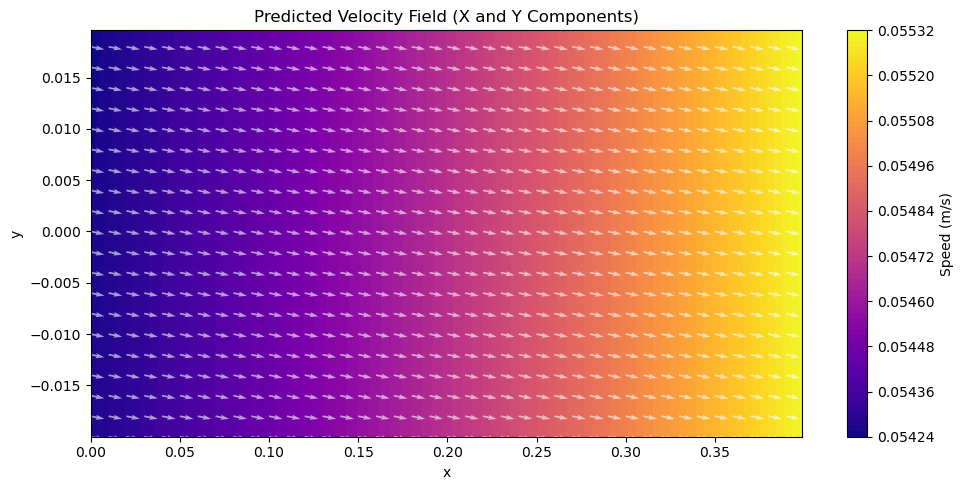

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

to_infer = []

for i in range(-50, 50, 1):
    for j in range(0, 400, 1):
        to_infer.append([j/1000, i/2500])

tensor = torch.from_numpy(np.array(to_infer)).float().to(device).requires_grad_(True)

yhp = poiseuille_model(tensor)

# Detach and convert
u_pred = yhp[:, 0].detach().cpu().numpy()
v_pred = yhp[:, 1].detach().cpu().numpy()
x = tensor[:, 0].detach().cpu().numpy()
y = tensor[:, 1].detach().cpu().numpy()

# Create dataframe
df = pd.DataFrame({'x': x, 'y': y, 'u': u_pred, 'v': v_pred})
df['speed'] = (df['u']**2 + df['v']**2)**0.5

# Pivot for grid-based plotting
pivot_x = df.pivot_table(index='y', columns='x', values='u')
pivot_y = df.pivot_table(index='y', columns='x', values='v')
pivot_speed = df.pivot_table(index='y', columns='x', values='speed')

# Get meshgrid
X, Y = np.meshgrid(pivot_x.columns.values, pivot_x.index.values)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.contourf(X, Y, pivot_speed.values, levels=100, cmap='plasma')
cb = fig.colorbar(c, ax=ax, label='Speed (m/s)')

# Optional quiver (velocity vectors, skip some for clarity)
skip = (slice(None, None, 5), slice(None, None, 10))
ax.quiver(X[skip], Y[skip], pivot_x.values[skip], pivot_y.values[skip], color='white', alpha=0.6)

# Styling
ax.set_title('Predicted Velocity Field (X and Y Components)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('auto')
plt.tight_layout()
plt.show()